In [2]:
!pip install osmnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.9/102.9 kB 1.5 MB/s eta 0:00:00


In [3]:
# import relevant libraries
import osmnx as ox
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tqdm import tqdm
import matplotlib.colors as mcolors

# **Modified ChatGPT Code**

In [105]:

class Car:
    """
    Class to create an instance of car.
    """
    def __init__(self, start, destination, id, graph):
        """
        Attributes:
        - current_location: The current node of the car (initialized at start location)
        - destination: The destination node of the car
        - path: List of nodes outlining the shortest path of the car to get from start to desination
        - id: The id of the car (defined by the place it has been defined)
        - in_transit: binary, True when car has not reached final dest, False when it has.
        """
        self.current_location = start
        self.destination = destination
        self.path = nx.shortest_path(graph, start, self.destination, weight="travel_time")
        self.in_transit = True
        self.id = id

class Traffic_Flow:
    """
    Class to create an instance of the traffic flow given some specific city graph.
    """

    def __init__(self, city_graph, num_cars=100, num_steps=100, jam_threshold = 5):
        """
        Parameterized Attributes:
        - city_graph: the inputed graph network
        - num_cars: the number of cars that will be traversing through network (default = 100 cars)
        - num_steps: total number of time steps (default = 100 time steps)
        - jam_threshold: the threshold of cars on one edge required for a traffic jam to occur (default=5 cars)
        Attributes:
        - place_nodes: the nodes of the graph network
        - cars: a list of the all the object cars from class Car
        - step_count: a count of how many steps have passed at any given time (initialized to 0)
        """
        self.city_graph = city_graph
        self.place_nodes = list(city_graph.nodes())
        self.num_cars = num_cars
        self.num_steps = num_steps
        self.cars = []
        self.step_count = 0
        self.jam_threshold = jam_threshold

    def initialize(self): # might need to fix this to make sure that there is always a possible path
        """
        Initialize car objects to store in self.cars and initialize network plot.
        """
        # initialize cars with random but nonequal start and end nodes w/ a path
        for car in range(self.num_cars):
            path_found = False
            while path_found == False:
              start_node = random.choice(self.place_nodes)
              self.place_nodes.remove(start_node)
              end_node = random.choice(self.place_nodes)
              self.place_nodes.append(start_node)
              if nx.has_path(self.city_graph, start_node, end_node) == True:
                car = Car(start_node, end_node, car, self.city_graph)
                self.cars.append(car)
                path_found = True

        # initialize the network visualization
        self.figure, self.axes = ox.plot_graph(self.city_graph, figsize=(10, 10), show = False, close=False)

    def move_car_one_step(self, car):
        """
        Move a car object from current node along path to the next node for one step.
        """
        if car.current_location == car.destination: # Check if car has reached its destination
            car.in_transit = False # the car is no longer in transit
            #print(f"Car {car.id} reaches destination @ step {self.step_count}")
            self.cars.remove(car) # remove car from the list of cars.
        else: # If the car is still along path,
            next_place_node = car.path.pop(0) # Retrieve next move of car

            # Simulate traffic jam: if there are more than the jam threshold of cars on an edge, slow down
            traffic_count = self.curr_traffic(car.current_location, next_place_node)[0]
            if self.curr_traffic(car.current_location, next_place_node)[0] > self.jam_threshold:  # Arbitrary threshold for a "jam"
                first_in_line = self.curr_traffic(car.current_location, next_place_node)[1]
                # if the car is first in line, it will move, but the rest will not
                if car.id == first_in_line:
                  car.current_location = next_place_node
                else:
                  car.path.insert(0, next_place_node)  # Car stays in the same spot !! need to fix this
            # In the case of no traffic jam, the car will travel to the next node.
            else:
                car.current_location = next_place_node # Otherwise, the car moves to next spot.
                #print(f"Car {car.id} has moved to location: {next_place_node}")

    def move_all_one_step(self):
        """
        Move all cars by one time step.
        """
        for car in self.cars: # Move each car in the list of cars with unfinished path.
            self.move_car_one_step(car)
        self.step_count += 1

    def curr_traffic(self, current_node, next_node):
        """
        Measure the current traffic at one edge (between current and next node)
        """
        traffic_count = sum(1 for car in self.cars if car.current_location == current_node and car.path and car.path[0] == next_node)
        # save the first car in line, which will be moved in the case of a traffic jam
        cars_in_line = [car.id for car in self.cars if car.current_location == current_node and car.path and car.path[0] == next_node]

        if cars_in_line:
            first_in_line = min(cars_in_line)
            return traffic_count, first_in_line
        return [traffic_count]
    def count_edges(self):
        """
        Count the edges that cars are currently between and store as a dictionary.
        """
        edge_counts = {(source_node, target_node, 0): 0 for source_node, target_node, _, in self.city_graph.edges(keys=True)}
        for car in self.cars:
            if len(car.path) > 1:
                next_node = car.path[1]
                edge_counts[(car.path[0], next_node, 0)] += 1
        return edge_counts

    def count_nodes(self):
        """
        Count the place nodes that cars are currently located at.
        """
        node_counts = {node: 0 for node in self.place_nodes}
        for car in self.cars:
          node_counts[car.current_location] += 1 # count cars at each node

    def travel_times(self):#gotta fix this one too
        """
        Calculate the travel time between one edge and another.
        """
        # Add a 'travel_time' attribute to each edge to use as weight (for now, assume time is inversely proportional to speed limit, with a default of 30 km/h)
        for source_node, target_node, k, data in self.city_graph.edges(data=True, keys=True):
            speed = data.get("maxspeed", 30)
            if isinstance(speed, list):  # There can be multiple speed limits; take the first one as representative
                speed = speed[0]
            data["travel_time"] = data["length"] / (float(speed) * 1000/60)  # length in meters, speed in km/h, result in minutes
        return data["travel_time"]

    def visualize_traffic(self):
        """
        Visualize the traffic flow of the city graph.
        """
        edge_colors = []
        edge_widths = []
        car_edge_count = self.count_edges() # count cars on each edge
        max_car_edge_count = max(self.count_edges().values(), default=0) # save # of cars on most congested road/edge
        if max_car_edge_count == 0: # if there are no cars on any edge, return an empty graph.
          ox.plot_graph(self.city_graph, figsize=(10, 10), show=False, close=False, ax=self.axes)
        else: # otherwise, plot the cars on the graph by varying the weights and color of the edges.
          for start, end, _, data in self.city_graph.edges(data=True, keys=True): # determine the coloring and width of the edges
              count_cars = car_edge_count.get((start, end, 0))
              edge_colors.append(plt.cm.Reds(count_cars / max_car_edge_count)) # the color of edge depends on the ratio of the max cars on edge
              edge_widths.append(1 + count_cars) # the width depends on this as well❣️❣️ FIX this description

          ox.plot_graph(self.city_graph, figsize=(10, 10), edge_color=edge_colors, edge_linewidth=edge_widths, show=False, close=False, ax=self.axes)

        self.axes.set_title(f"Step: {self.step_count}")

        return self.figure, self.axes

def make_animation(sim, total_frames, steps_per_frame=1, interval=50, save_path = False):
    """
    Create a visualization of the movement over defined time steps.
    Function modified from class session [insert class session]
    """
    def update(frame_number):
        for _ in range(steps_per_frame):
          sim.move_all_one_step()
        progress_bar.update(1)
        return [sim.visualize_traffic()]

    sim.initialize()
    progress_bar = tqdm(total=total_frames)
    animation = FuncAnimation(
        sim.figure, update, init_func=lambda: [], frames=total_frames+1, interval=interval)
    animation = HTML(animation.to_html5_video())
    #sim.figure.clf()
        # Save the animation frames
    if save_path:
        animation.save(save_path, writer='ffmpeg', fps=2)

    progress_bar.close()
    sim.figure.clf()

    return animation

city_graph = ox.graph_from_address('Adalbertstraße 58, Berlin, Germany', dist=1000, network_type='drive')
traffic_sim = Traffic_Flow(city_graph, num_cars=100)
make_animation(traffic_sim, total_frames=100, steps_per_frame=1, interval=100)



101it [03:46,  2.24s/it]


<Figure size 1000x1000 with 0 Axes>

# **Improved Version of Simulation**

In [77]:
# Define colors for the custom scale: white (no congestion), yellow (medium congestion), red (high congestion)
cmap_colors = [(1, 1, 1), (1, 1, 0), (1, 0, 0)]  # RGB colors

cmap_name = 'custom_traffic_cmap'
custom_cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, cmap_colors)

In [100]:

class Car:
    """
    Class to create an instance of car in traffic flow.
    """
    def __init__(self, start, destination, id, graph, traffic_flow):
        """
        Attributes:
        - current_location: The current node of the car (initialized at start location)
        - destination: The destination node of the car
        - path: List of nodes outlining the shortest path of the car to get from start to desination
        - in_transit: Binary, True when car has not reached final dest, False when it has.
        - id: The id of the car (defined by the place it has been defined)
        - speed: the current speed of car (accelerates from 0)
        - position_on_road: what fraction of a given edge the car has traveled through
        - current_edge: the current road/edge of the car.
        - traffic_flow: Imported traffic flow instance
        """
        self.current_location = start
        self.destination = destination
        self.path = nx.shortest_path(graph, start, self.destination, weight="travel_time")
        self.in_transit = True
        self.id = id
        self.speed = 0 # current speed - all initialized to 0
        self.position_on_road = 0 # position along road edge
        self.current_edge = (self.current_location, self.path[1]) # the edge they are currently on
        self.traffic_flow = traffic_flow

    def update_position(self): # need the length of the road here
        """
        Update car's position along the current edge.
        """
        # calculate distance traveled along current node.
        length_of_road = self.traffic_flow.length_dict[self.current_edge]
        self.position_on_road += self.speed / length_of_road

        # Check if car has reached the end of the edge/road
        if self.position_on_road >= 1:
            # if so, and there is a leftover distance, move to the next road.
            distance_left = (self.position_on_road - 1)*length_of_road
            self.position_on_road = 0 # car is now at the start of the next position
            self.move_to_next_node(distance_left) # move the car to the next road

    def move_to_next_node(self, distance_left):
        """
        Update car's position to the next node in path.
        """
        self.current_location = self.path.pop(0)  # update to the next node in path

        if len(self.path) >= 1:  # if there is still a path to go
            self.current_edge = (self.current_location, self.path[0])
            length_of_next_road = self.traffic_flow.length_dict[self.current_edge]

            # update car's speed based on conditions of new edge
            next_car_distance = self.traffic_flow.distance_to_next_car(self, self.current_edge)
            road_max_speed = self.traffic_flow.max_v_dict[self.current_edge]
            self.update_speed(next_car_distance, road_max_speed)

            # Calculate the new position on the next road, considering the leftover distance
            self.position_on_road = min(distance_left, next_car_distance - 1, road_max_speed) / length_of_next_road

            # Check if there is still distance left to move
            if self.position_on_road >= 1:
                self.move_to_next_node((self.position_on_road - 1)*length_of_next_road)
        else:
            self.in_transit = False  # Car has reached final destination

    def update_speed(self, next_car_distance, road_max_speed):
        """
        Update the car's speed based on the Nagel-Schreckenberg model (without randomized slow-downs)
        """
        if self.speed < road_max_speed:
            self.speed += 1  # Acceleration

        if self.speed > next_car_distance:
            self.speed = next_car_distance - 1 # Deceleration with 1 meter buffer


class Traffic_Flow:
    """
    Class to create an instance of the traffic flow given some specific city graph.
    """

    def __init__(self, city_graph, num_cars=100, num_steps=100):
        """
        Parameterized Attributes:
        - city_graph: Inputed graph network from osmnx
        - num_cars: Number of cars that will be traversing through network (default = 100 cars)
        - num_steps: Total number of time steps (default = 100 time steps)
        Attributes:
        - place_nodes: List of nodes of the graph network
        - cars: List of the all the object cars from class Car
        - step_count: Integer count of how many steps have passed at any given time (initialized to 0)
        - max_v_dict: Dictionary of the max speed limits in graph (taken from city_graph)
        - time_step: Integer value of time passed per simulation step
        - aggregated_congestion: Dictionary counter for the aggregated congestion for all time steps
        """
        self.city_graph = city_graph
        self.place_nodes = list(city_graph.nodes())
        self.num_cars = num_cars
        self.num_steps = num_steps
        self.cars = []
        self.step_count = 0
        self.max_v_dict = {max_speed: 0 for max_speed in self.city_graph.edges()}
        self.length_dict = {edge: city_graph.get_edge_data(edge[0], edge[1])[0]['length'] for edge in self.city_graph.edges()}
        self.time_step = 1 # in seconds
        self.aggregated_congestion = {edge: 0 for edge in self.city_graph.edges()}
        self.max_flow = {max_flow: 0 for max_flow in self.city_graph.edges()}
        self.safe_distance = 5

    def init_max_speeds(self):
        """
        Initialize and clean values for the max road speeds from city_graph data.
        """
        for edge in self.city_graph.edges():
          # get attributes for the selected edge
          edge_data = self.city_graph.get_edge_data(*edge)

          # find the max speed attribute - will require data cleaning
          max_speed = edge_data[0].get('maxspeed', 'N/A')
          if max_speed == 'N/A': # if a road doesn't contain speed data, we will assign one intuitively
            max_speed = 40
          if type(max_speed) == list: # some roads contain multiple speeds, we will find the mean
            max_speed = np.mean([int(speed_val) for speed_val in max_speed])
          max_speed = int(max_speed) # change all string max_speed to integer
          self.max_v_dict[edge] = max_speed # store in dictionary
        return self.max_v_dict

    def init_max_flows(self):
        """
        Initialize the maximum possible flow of all edges.
        """
        for edge in self.city_graph.edges():
            # calculate max "safe" density - assume that all cars must have 3 m of space between
            max_density = (self.length_dict[edge] / self.safe_distance) / self.length_dict[edge]

            # find max road speed
            max_speed = self.max_v_dict[edge]
            # calculate max possible flow
            self.max_flow[edge] = max_density * max_speed
        return self.max_flow

    def initialize(self):
        """
        Initialize speeds + car objects to store in self.cars.
        """
        # Initialize cars with random but nonequal start and end nodes w/ a path
        for car in range(self.num_cars):
            path_found = False
            while path_found == False:
              start_node = random.choice(self.place_nodes)
              self.place_nodes.remove(start_node)
              end_node = random.choice(self.place_nodes)
              self.place_nodes.append(start_node)
              if nx.has_path(self.city_graph, start_node, end_node) == True:
                car = Car(start_node, end_node, car, self.city_graph, self)
                self.cars.append(car)
                path_found = True

        # Initialize max speeds
        self.max_v_dict = self.init_max_speeds()
        self.max_flow = self.init_max_flows()

    def initialize_viz(self):
        """
        Initialize the simulation visualization.
        """
        # initialize the network visualization
        self.figure, self.axes = ox.plot_graph(self.city_graph, figsize=(10, 10), show = False, close=False)

        # defne a color bar to understand road colors
        sm = plt.cm.ScalarMappable(cmap=custom_cmap)
        # Adjust the size and position of the color bar
        cbar = self.figure.colorbar(sm, ax=self.axes, orientation='vertical', aspect=20, shrink=0.75)
        cbar.set_label("Congestion Level")

    def distance_to_next_car(self, car, current_road):
        """
        Calculate distance to the next car on same edge.
        """
        car_distances = []
        for other_car in self.cars:
            # if car is itself or is not on the same road, no distance is added.
            if other_car == car or other_car.current_edge != car.current_edge:
                continue
            # calculate the distance to the cars ahead on the same road
            else:
                distance = (other_car.position_on_road - car.position_on_road) * self.length_dict[current_road]
                if distance > 0:
                    car_distances.append(distance)

        # if no cars ahead
        if not car_distances:
            return float('inf')
        return min(car_distances) # return distance to next car in front

    def move_car_one_step(self, car):
        """
        Move a car object for one time step.
        """
        # if the car is at destination, remove from list.
        if car.current_location == car.destination:
            car.in_transit = False
            self.cars.remove(car)
            return

        # else, calculate the updated speed and position of car
        speed_limit = self.max_v_dict[car.current_edge]
        next_car_distance = self.distance_to_next_car(car, car.current_edge)
        car.update_speed(next_car_distance, speed_limit)
        car.update_position()

    def move_all_one_step(self):
        """
        Move all cars by one time step.
        """
        # Move each car in the list of cars with unfinished path.
        for car in self.cars:
            self.move_car_one_step(car)
        self.step_count += 1

        # aggregate congestion levels
        self.aggregate_congestion()

    def calculate_density(self):
        """
        Calculate density of edge: number of cars / length of edge.
        Returns dictionary of densities for each edge.
        """
        density = {edge: 0 for edge in self.city_graph.edges()}
        for car in self.cars:
            edge = car.current_edge
            density[edge] += 1 / self.length_dict[edge]
        return density

    def calculate_av_speeds(self):
        """
        Calculate the average speed of cars on an edge.
        Returns dictionary of average car speed values for edges.
        """
        edge_car_counts = {edge: 0 for edge in self.city_graph.edges()}
        edge_car_speeds = {edge: 0 for edge in self.city_graph.edges()}
        for car in self.cars:
            edge = car.current_edge
            edge_car_counts[edge] += 1
            edge_car_speeds[edge] += car.speed
        av_speeds = {edge: np.mean(edge_car_speeds[edge])  for edge in self.city_graph.edges()}
        return av_speeds

    def measure_traffic_flow(self):
        """
        Measure traffic flow of each edge with Nagel-Schreckenberg equation.
        Returns dictionary of flow values for edges.
        """
        # Calculate flow: average speed * car density
        av_speeds = self.calculate_av_speeds()
        car_densities = self.calculate_density()
        traffic_flow = {edge: av_speeds[edge]* car_densities[edge] for edge in self.city_graph.edges()}
        return traffic_flow

    def calculate_congestion(self):
        """
        Calculate congestion as an inverted value of traffic flow values weighted by current edge's theoretical maximum flow:
        - higher flow -> lower congestion
        - lower flow -> higher congestion
        Returns dictionary of congestion values.
        """
        # invert the flow values for coloring: lower flow = higher value
        traffic_flow = self.measure_traffic_flow()
        congestion = {edge: 0 for edge in self.city_graph.edges()}
        for edge in self.city_graph.edges():
            if traffic_flow[edge] == 0:
                congestion[edge] = 0 # if no cars, we say no flow
            else:
                congestion[edge] = 1 - min(1, abs((traffic_flow[edge] / self.max_flow[edge])))
        return congestion


    def aggregate_congestion(self):
        """
        Aggregate congestion values at each time step.
        Returns dictionary of aggregated congestion values.
        """
        # obtain current congestion
        congestion = self.calculate_congestion()

        # Aggregate congestion data
        for edge in self.city_graph.edges():
            if congestion[edge] == 0:
                # if no flow, we add 0, knowing that higher flow = lower congestion
                self.aggregated_congestion[edge] += 0
            else:
                self.aggregated_congestion[edge] += congestion[edge]

        return self.aggregated_congestion

    def visualize_traffic(self):
        """
        Visualize the traffic flow of the city graph with cars moving along edges.
        Edge colors will be...
        - gray is no cars on edge
        - ranging between white, yellow, and red for how "congested" the flow is.
        Returns visualization
        """

        # clear axes
        self.axes.clear()

        # Calculate and normalize traffic flow
        congestion = self.calculate_congestion()

        edge_colors = []
        for edge in self.city_graph.edges():
            if congestion[edge] == 0:
                edge_colors.append(mcolors.to_rgba('gray'))
            else:
                edge_colors.append(custom_cmap(1 - congestion[edge]))

        # plot graph with customized edge colors
        ox.plot_graph(self.city_graph, ax=self.axes, edge_color=edge_colors, node_size=0, show=False, close=False)

        # plot car positions at each time step
        for car in self.cars:
            if len(car.path) > 0:
                # get the positions of the current and next node in the path
                current_node_pos = self.city_graph.nodes[car.current_location]
                next_node_pos = self.city_graph.nodes[car.path[0]]

                # interpolate the car's position along the edge
                interpolated_x = (1 - car.position_on_road) * current_node_pos['x'] + car.position_on_road * next_node_pos['x']
                interpolated_y = (1 - car.position_on_road) * current_node_pos['y'] + car.position_on_road * next_node_pos['y']

                # plot the car's position
                self.axes.scatter(interpolated_x, interpolated_y, color='white', s=20, label=f'Car {car.id}')

        self.axes.set_title(f"Step: {self.step_count}")
        return self.figure, self.axes


In [24]:
def make_animation(sim, total_frames, steps_per_frame=1, interval=50, save_path = False):
    """
    Create a visualization of the movement over defined time steps.
    Function modified from class session [insert class session]
    """
    sim.initialize_viz()
    def update(frame_number):
      sim.move_all_one_step()
      progress_bar.update(1)
      sim.visualize_traffic()
      return [sim.axes]
    sim.initialize()
    progress_bar = tqdm(total=total_frames)
    animation = FuncAnimation(
        sim.figure, update, init_func=lambda: [], frames=total_frames+1, interval=interval)
    animation = HTML(animation.to_html5_video())
    #sim.figure.clf()
        # Save the animation frames
    if save_path:
        animation.save(save_path, writer='ffmpeg', fps=2)

    progress_bar.close()
    sim.figure.clf()

    return animation



In [6]:
# define our city graph in Berlin
city_graph = ox.graph_from_address('Adalbertstraße 58, Berlin, Germany', dist=1000, network_type='drive')

In [102]:
traffic_sim = Traffic_Flow(city_graph, num_cars= 200)
make_animation(traffic_sim, total_frames=100, steps_per_frame=1, interval=200)

101it [02:55,  1.74s/it]


<Figure size 1000x1000 with 0 Axes>

## **Empirical analysis with simulation**



In [43]:
def run_simulations(city_graph, num_trials, num_cars=200, num_steps=200):
    """
    Run simulation over trials to determine most congested roads.
    """
    av_congestion_over_trials = {edge: 0 for edge in city_graph.edges()}
    most_congested = {}
    for _ in range(num_trials):
        sim = Traffic_Flow(city_graph, num_cars, num_steps)
        sim.initialize()
        for _ in range(num_steps):
            sim.move_all_one_step()

        # average congestion data by the number of steps
        trial_av_congestion = {edge: 0 for edge in city_graph.edges()}
        for edge in city_graph.edges():
            trial_av_congestion[edge] = sim.aggregated_congestion[edge] / num_steps
            av_congestion_over_trials[edge] += trial_av_congestion[edge] / num_trials
        top_congested = sorted(trial_av_congestion.items(), key=lambda x: x[1], reverse=True)[:1]
        for key, value in top_congested:
            if str(key) in most_congested:
                most_congested[str(key)] += 1
            else:
                most_congested[str(key)] = 1

    return av_congestion_over_trials, most_congested



def return_max_ten(data_to_sort):
    """
    Sort values for analysis, return top 10.
    """
    # sort edges by average congestion
    top_ten = dict(sorted(data_to_sort.items(), key=lambda x: x[1], reverse=True)[:10])
    return top_ten


def graph_congestion(city_graph, congestion_values, title):
    """
    Graph the average congestion of edges in network
    """
    # normalize congestion values
    normed = mcolors.Normalize(vmin=min(congestion_values.values()), vmax=max(congestion_values.values()))
    edge_colors = [custom_cmap(normed(congestion_values[edge[0], edge[1]])) for edge in city_graph.edges()]

    # create the graph visualization
    fig, ax = ox.plot_graph(city_graph, node_size=0, node_color='w', edge_color=edge_colors, edge_linewidth=1.5, figsize=(10, 10), show=False)

    # create a colorbar legend for edge betweenness centrality
    sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=normed)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5)
    cbar.set_label('Average Congestion')
    plt.title(str(title))
    plt.show()

def graph_bar(frequency_dict, title, xlabel, ylabel):
    """
    Create bar graph of 10 highest frequency values in a dictionary
    """
    plt.bar(frequency_dict.keys(), frequency_dict.values(), color="black")
    plt.xticks(rotation=90)
    plt.xlabel(str(xlabel))
    plt.ylabel(str(ylabel))
    plt.title(str(title))
    plt.tight_layout()
    plt.show()


In [36]:
# run simulations to find the most congested
num_runs = 100  # Number of simulation runs

# run simulation
av_congestion_results_berlin, most_congested_berlin = run_simulations(city_graph, num_runs)


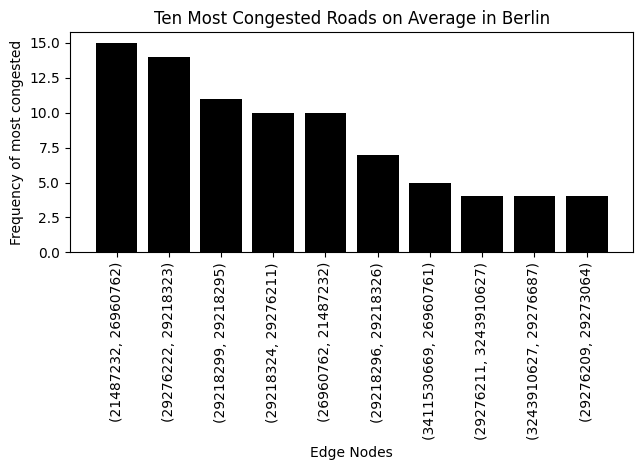

In [58]:
# graph the congestion
graph_congestion(city_graph, av_congestion_results_berlin, "Berlin Heat Mapping of Average Congestion")

# return the ten most congested roads on average
top_ten_berlin = return_max_ten(most_congested_berlin)

# graph a bar chart of the ten most congested roads
graph_bar(top_ten_berlin, "Ten Most Congested Roads on Average in Berlin", "Edge Nodes", "Frequency of most congested")



## **Theoretical analysis with network metrics - betweeness**

In [48]:
def calculate_betweenness(city_graph):
    """
    Calculating edge betweenness of graph.
    """
    # calculate edge betweenness centrality
    edge_betweenness = nx.edge_betweenness_centrality(city_graph, normalized=True)
    return edge_betweenness

def graph_betweenness(city_graph, betweenness_values, title):
    """
    Graph the betweenness centrality of edges.
    """
    # normalize betweenness values for coloring
    normed = mcolors.Normalize(vmin=min(betweenness_values.values()), vmax=max(betweenness_values.values()))
    edge_colors = [custom_cmap(normed(betweenness_values[edge[0], edge[1], 0])) for edge in city_graph.edges()]

    # create the graph visualization
    fig, ax = ox.plot_graph(city_graph, node_size=0, node_color='w', edge_color=edge_colors, edge_linewidth=1.5, figsize=(10, 10), show = False)

    # define color map
    sm = plt.cm.ScalarMappable(cmap=custom_cmap)
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', aspect=20, shrink=0.5)
    cbar.set_label('Edge Betweenness Centrality')
    plt.title(str(title))
    plt.show()


def graph_bar_betweenness(top_five, title, xlabel, ylabel):

    # extract edge labels and centrality scores for plotting
    edge_labels = ['{}-{}'.format(edge[0], edge[1]) for edge in top_five.keys()]
    centrality_values = list(top_five.values())

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(centrality_values)), centrality_values, tick_label=edge_labels, color='black')
    plt.xticks(rotation=90)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

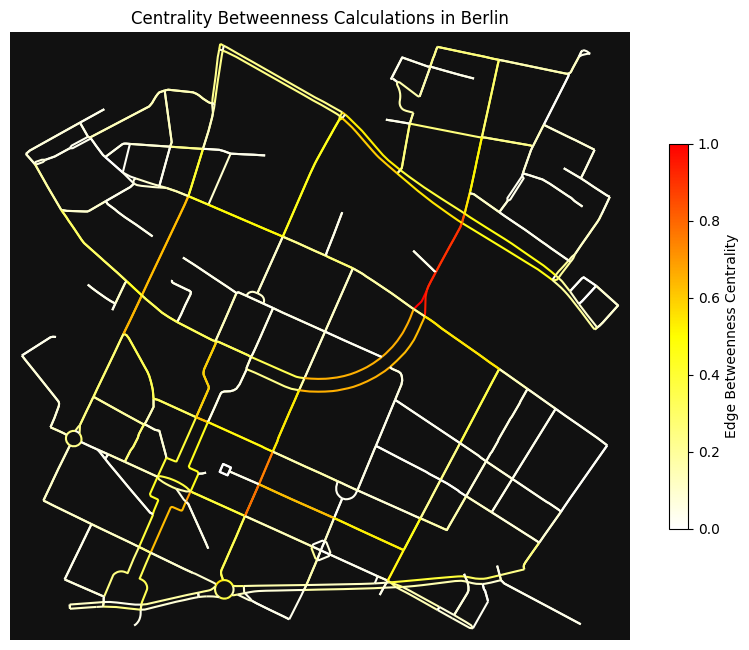

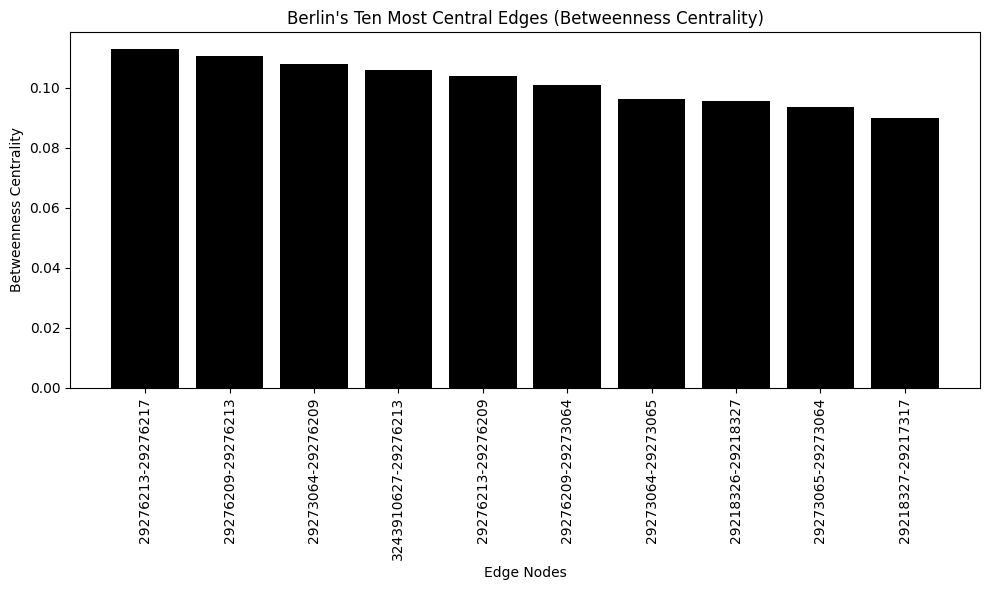

In [61]:

# calculate edge betweenness centrality for Berlin network
betweenness_values_berlin = calculate_betweenness(city_graph)

# calculate 10 most "central" edges
top_ten_central_berlin = return_max_ten(betweenness_values_berlin)

# graph the centrality betweeness
graph_betweenness(city_graph, betweenness_values_berlin, "Centrality Betweenness Calculations in Berlin")

# graph bar chart of betweenness centrality
graph_bar_betweenness(top_ten_central_berlin, "Berlin's Ten Most Central Edges (Betweenness Centrality)", "Edge Nodes", "Betweenness Centrality")


# **Application to location in Buenos Aires (Palermo)**

In [50]:
# define city graph in Buenos Aires
palermo_graph = ox.graph_from_address('Junín 1930, C1113 CABA, Buenos Aires, Argentina', dist=1000, network_type='drive')

In [ ]:
# make animation of traffic
traffic_sim_palermo = Traffic_Flow(palermo_graph, num_cars= 200)
make_animation(traffic_sim_palermo, total_frames=200, steps_per_frame=1, interval=200)

201it [03:14,  1.03it/s]


<Figure size 1000x1000 with 0 Axes>

In [51]:
# run simulations to find the most congested roads
num_runs = 100  # Number of simulation runs

# run simulation
av_congestion_results_BA, most_congested_BA = run_simulations(palermo_graph, num_runs)

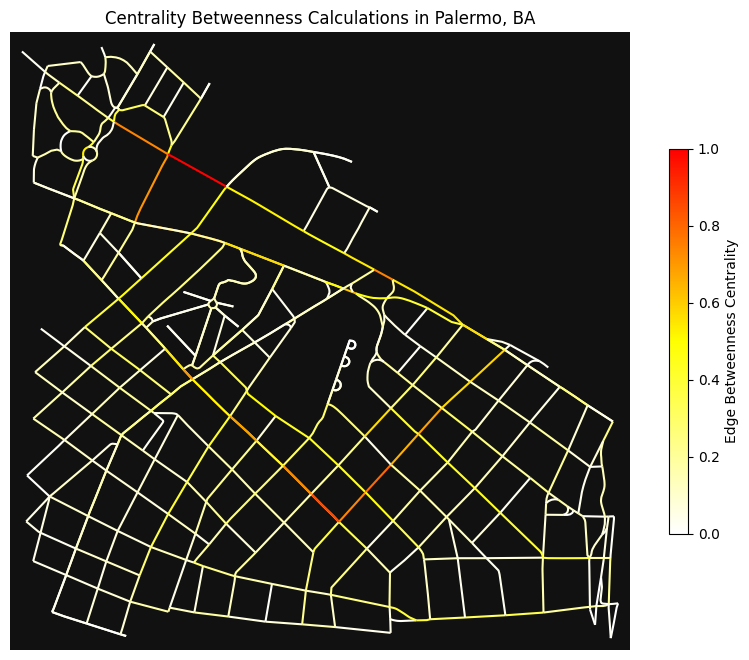

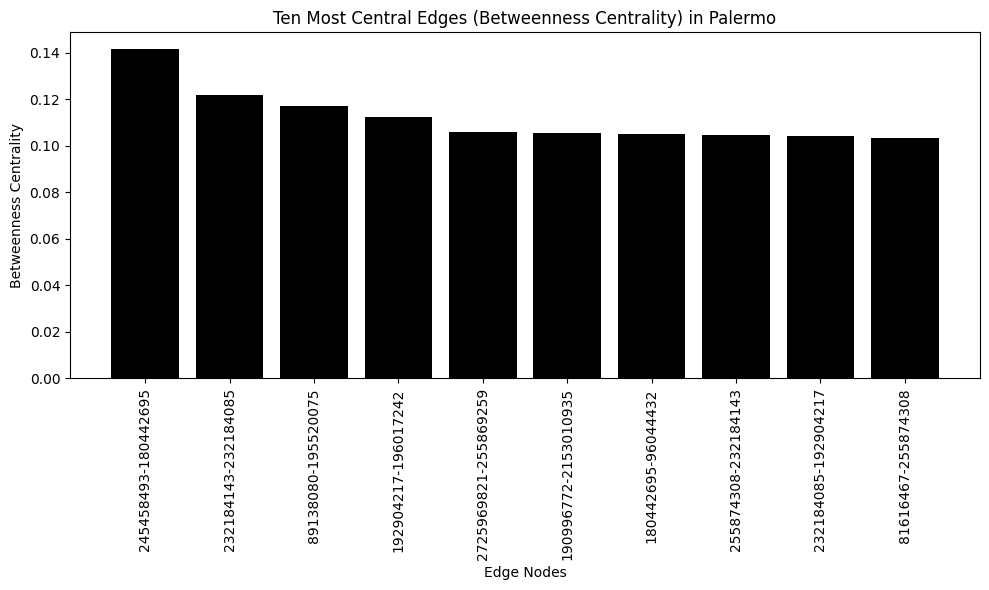

In [65]:
# find and graph betweenness metrics
palermo_betweenness_values = calculate_betweenness(palermo_graph)
graph_betweenness(palermo_graph, palermo_betweenness_values, "Centrality Betweenness Calculations in Palermo, BA")

# calculate 10 most "central" edges
top_ten_central_palermo = return_max_ten(palermo_betweenness_values)
graph_bar_betweenness(top_ten_central_palermo, "Ten Most Central Edges (Betweenness Centrality) in Palermo", "Edge Nodes", "Betweenness Centrality")

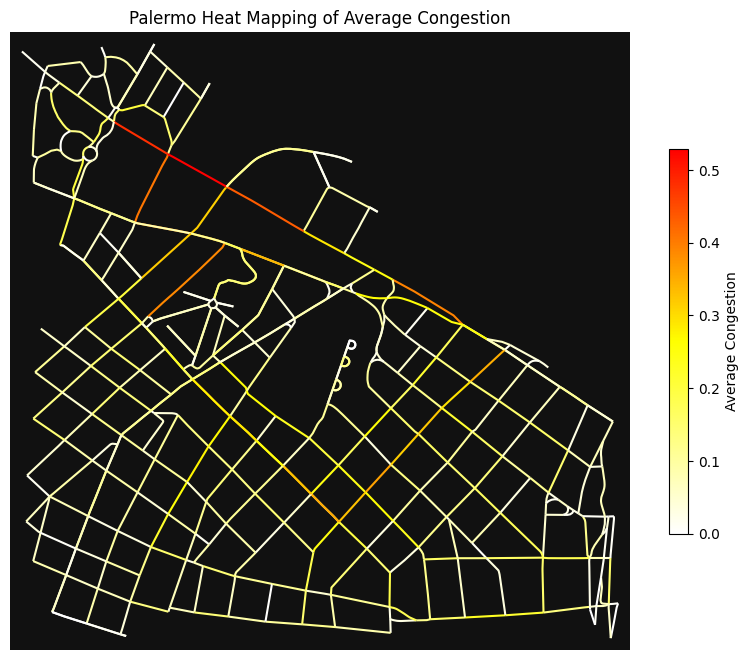

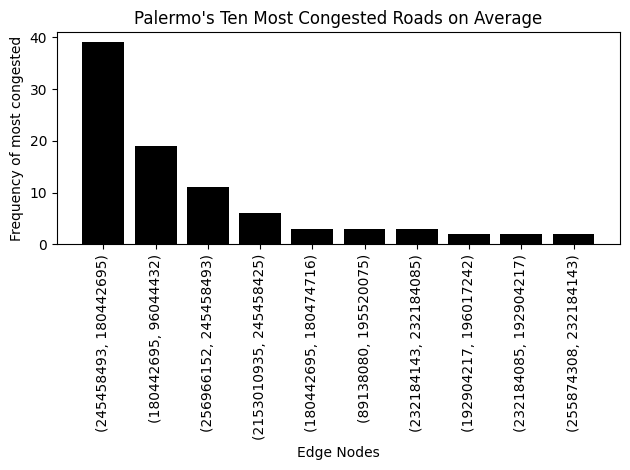

In [64]:
# graph congestion
graph_congestion(palermo_graph, av_congestion_results_BA, "Palermo Heat Mapping of Average Congestion")

# return the ten most congested roads on average
top_ten_BA = return_max_ten(most_congested_BA)

# graph a bar chart of the five most congested roads
graph_bar(top_ten_BA, "Palermo's Ten Most Congested Roads on Average", "Edge Nodes", "Frequency of most congested")

